# **INFO5731 Assignment 5**

---


**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100

**Full Points will be given those who present well**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

# **SENTIMENT ANALYSIS**

The objective of this assignment is to give you **hands-on experience** in applying various** sentiment analysis techniques** on real-world textual data. You are expected to explore data, apply machine learning models, and evaluate their performance

**1. Dataset Collection & Preparation**

Find a real-world dataset with text and positive, negative, and neutral sentiment labels.

Justify your dataset choice and handle **class imbalance** if needed.

**2. Exploratory Data Analysis (EDA)**

Clean and preprocess the data (tokenization, stopwords, lemmatization).

Perform EDA: class distribution, word clouds, n-gram analysis, sentence lengths, etc.

Visualize insights using relevant plots and charts.

**3. Sentiment Classification**

Apply at least three traditional ML models (e.g., SVM, Naive Bayes, XGBoost) using TF-IDF or embeddings.

If applicable, compare with a pretrained model (RoBERTa/BERT).

Tune hyperparameters and use cross-validation.

**4. Evaluation & Reporting**

Evaluate with metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.

Summarize results, compare models, and reflect on what worked.

In [5]:
!pip install -q nltk wordcloud seaborn scikit-learn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
df = pd.read_csv('/content/Tweets.csv')
df.columns = df.columns.str.strip()
df = df[['text', 'airline_sentiment']]
df.dropna(inplace=True)


In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove URLs, mentions, hashtags, punctuation
    text = re.sub(r"http\S+|www\S+|@\S+|[^a-zA-Z\s]", '', text)
    text = text.lower()
    tokens = text.split()  # avoid nltk.word_tokenize which triggers 'punkt_tab'
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Apply preprocessing
df['clean_text'] = df['text'].apply(clean_text)

# View cleaned text
df[['text', 'clean_text']].head()


text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                          clean_text  
0                                               said  
1       plus youve added commercial experience tacky  
2       didnt today must mean need take another trip  
3  really aggressive blast obnoxious entertainmen...  
4                               really big bad thing

<ipython-input-8-6526b7ca6777>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='Set2')


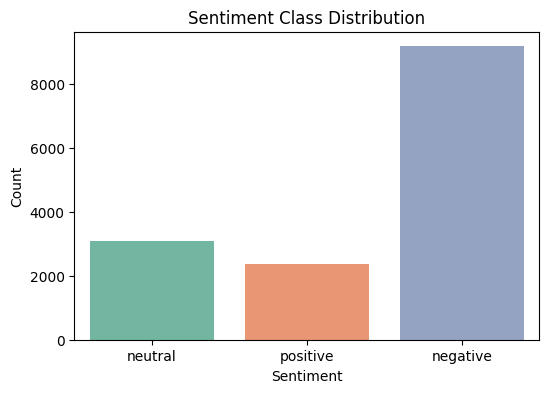

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='airline_sentiment', data=df, palette='Set2')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


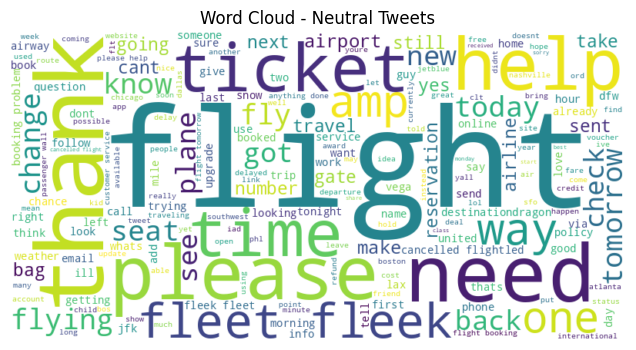

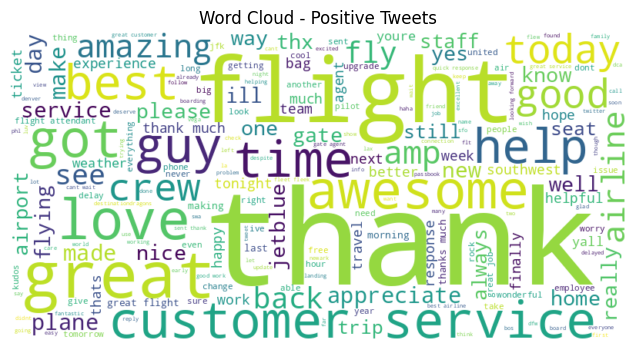

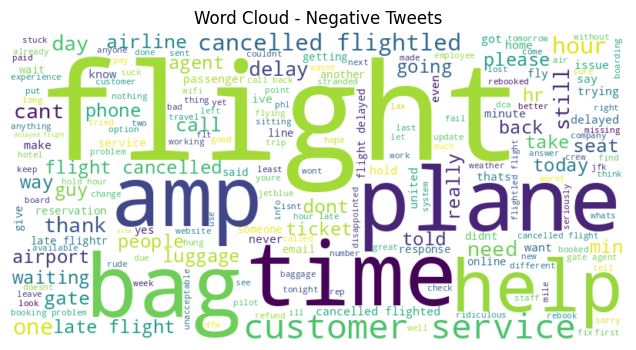

In [9]:
from wordcloud import WordCloud

for sentiment in df['airline_sentiment'].unique():
    text = " ".join(df[df['airline_sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {sentiment.capitalize()} Tweets")
    plt.show()

<ipython-input-12-3e7a6d0d68b2>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigrams_df, palette='Reds_d')


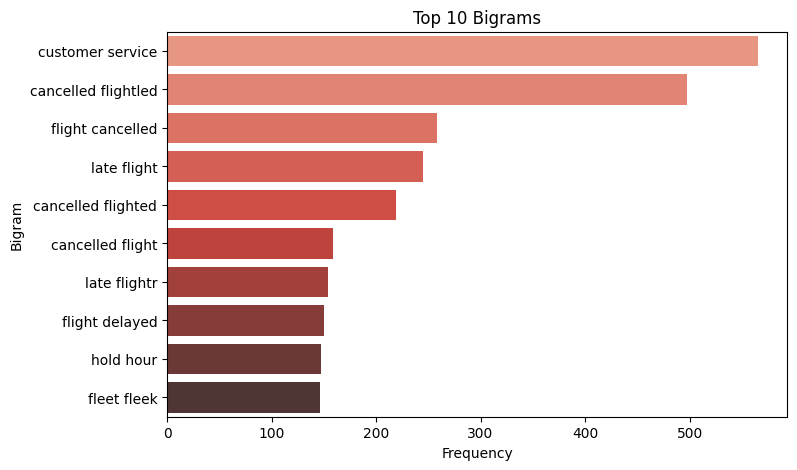

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_bigrams = get_top_ngrams(df['clean_text'], n=10)
bigrams_df = pd.DataFrame(top_bigrams, columns=["Bigram", "Frequency"])

plt.figure(figsize=(8, 5))
sns.barplot(x='Frequency', y='Bigram', data=bigrams_df, palette='Reds_d')
plt.title("Top 10 Bigrams")
plt.show()


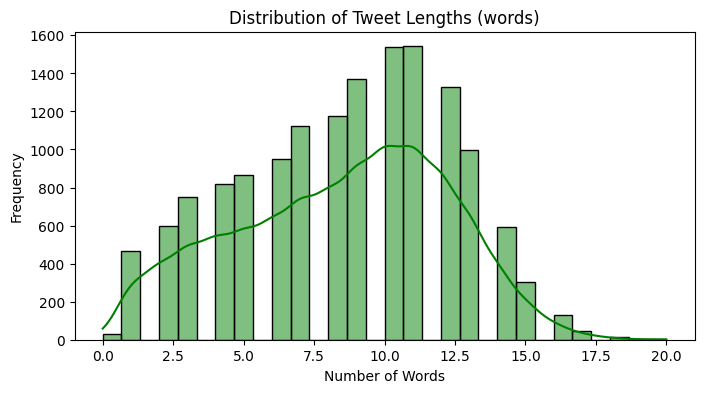

In [13]:
df['text_len'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
sns.histplot(df['text_len'], bins=30, kde=True, color='green')
plt.title("Distribution of Tweet Lengths (words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['airline_sentiment']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    print(f"🔍 Evaluation for {model_name}")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Oranges')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


🔍 Evaluation for Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      1835
           1       0.72      0.24      0.36       620
           2       0.83      0.34      0.48       473

    accuracy                           0.72      2928
   macro avg       0.75      0.52      0.56      2928
weighted avg       0.74      0.72      0.67      2928

Accuracy: 0.7237021857923497


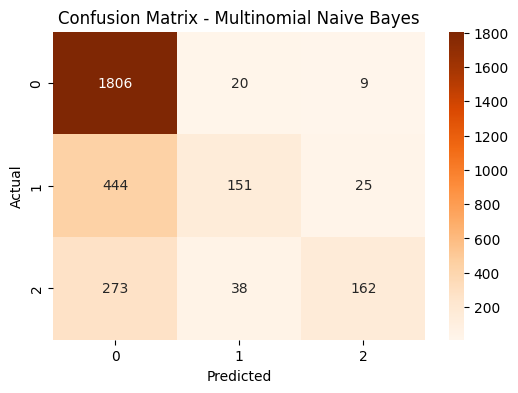

🔍 Evaluation for Linear SVM
              precision    recall  f1-score   support

           0       0.84      0.90      0.86      1835
           1       0.61      0.57      0.59       620
           2       0.75      0.61      0.67       473

    accuracy                           0.78      2928
   macro avg       0.73      0.69      0.71      2928
weighted avg       0.77      0.78      0.78      2928

Accuracy: 0.7800546448087432


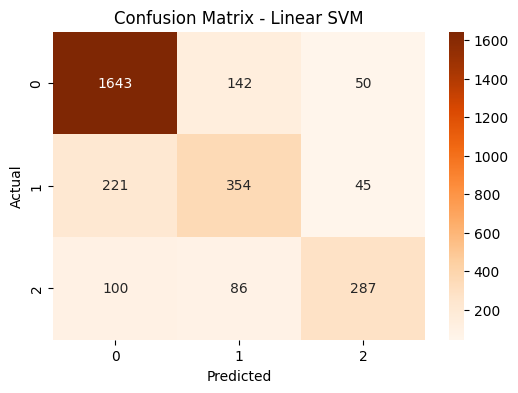

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:12:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Evaluation for XGBoost
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1835
           1       0.66      0.33      0.44       620
           2       0.77      0.56      0.65       473

    accuracy                           0.75      2928
   macro avg       0.73      0.61      0.64      2928
weighted avg       0.74      0.75      0.72      2928

Accuracy: 0.7503415300546448


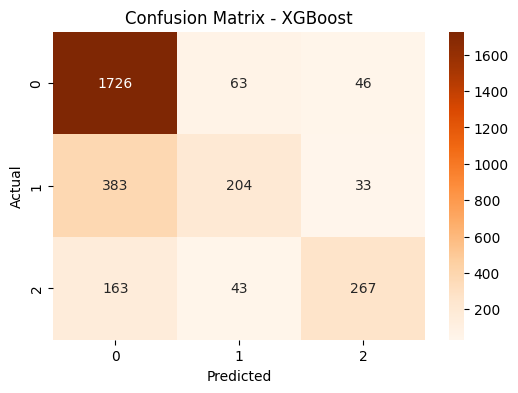

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# Encode the labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train_encoded)
evaluate_model(nb, X_test, y_test_encoded, "Multinomial Naive Bayes")

# SVM
svm = LinearSVC()
svm.fit(X_train, y_train_encoded)
evaluate_model(svm, X_test, y_test_encoded, "Linear SVM")

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train_encoded)
evaluate_model(xgb, X_test, y_test_encoded, "XGBoost")


## **Question 2 (30 Points)**

# **Text Classification**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.



1.   **Perform EDA on test and tran dataset**

2.   **Algorithms (Minimum 4):**

*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

3. **Evaluation measurement:**

*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [18]:
# Write your code here
!pip install xgboost

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Training Set Class Distribution:
label
1    3610
0    3310
Name: count, dtype: int64

Testing Set Class Distribution:
label
0    912
1    909
Name: count, dtype: int64


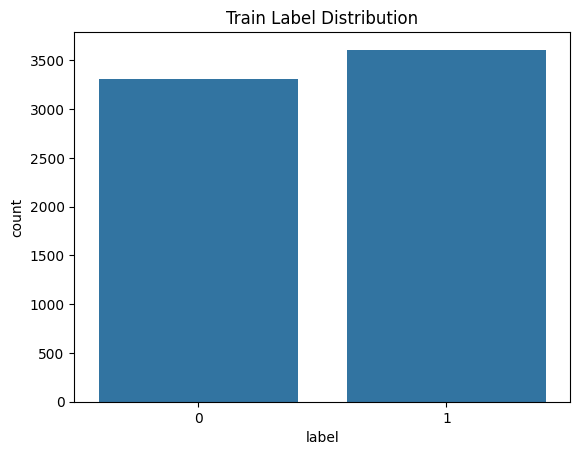


SVM Results:
Accuracy : 0.7869302580999451
Precision: 0.770508826583593
Recall   : 0.8162816281628162
F1 Score : 0.7927350427350427

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78       912
           1       0.77      0.82      0.79       909

    accuracy                           0.79      1821
   macro avg       0.79      0.79      0.79      1821
weighted avg       0.79      0.79      0.79      1821


KNN Results:
Accuracy : 0.514003294892916
Precision: 0.5594059405940595
Recall   : 0.12431243124312431
F1 Score : 0.20342034203420342

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.90      0.65       912
           1       0.56      0.12      0.20       909

    accuracy                           0.51      1821
   macro avg       0.53      0.51      0.43      1821
weighted avg       0.53      0.51      0.43      1821


Decision Tree Results:
Accu

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:17:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Accuracy : 0.6968698517298187
Precision: 0.6679209783631233
Recall   : 0.7810781078107811
F1 Score : 0.7200811359026369

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67       912
           1       0.67      0.78      0.72       909

    accuracy                           0.70      1821
   macro avg       0.70      0.70      0.69      1821
weighted avg       0.70      0.70      0.69      1821



In [19]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# STEP 2: LOAD AND PARSE DATA CORRECTLY
def load_stsa(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    labels = []
    texts = []
    for line in lines:
        line = line.strip()
        if line:
            labels.append(int(line[0]))
            texts.append(line[2:].strip())  # assuming format: "1 text..." or "0 text..."
    return pd.DataFrame({'label': labels, 'text': texts})

train_df = load_stsa('/content/stsa-train.txt')
test_df = load_stsa('/content/stsa-test.txt')

# STEP 3: EDA
print("Training Set Class Distribution:")
print(train_df['label'].value_counts())
print("\nTesting Set Class Distribution:")
print(test_df['label'].value_counts())

sns.countplot(data=train_df, x='label')
plt.title('Train Label Distribution')
plt.show()

# STEP 4: CLEANING TEXT
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

train_df['cleaned'] = train_df['text'].apply(clean_text)
test_df['cleaned'] = test_df['text'].apply(clean_text)

# STEP 5: TF-IDF VECTORIZATION
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['cleaned'])
X_test = vectorizer.transform(test_df['cleaned'])

y_train = train_df['label']
y_test = test_df['label']

# STEP 6: EVALUATION FUNCTION
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy :", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("Recall   :", recall_score(y_test, preds))
    print("F1 Score :", f1_score(y_test, preds))
    print("\nClassification Report:\n", classification_report(y_test, preds))

# STEP 7: TRAIN & EVALUATE MODELS
models = [
    ("SVM", SVC(kernel='linear')),
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

for name, model in models:
    evaluate_model(name, model)


## **Question 3 (30 Points)**

# **Text Clustering**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)


1.   Perform EDA on selected dataset

2.   **Apply the listed clustering methods ( Any 4) to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

3. **Visualize the clusters**

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [23]:
# STEP 1: INSTALL
!pip install gensim



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413770 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB
None

Sample Reviews:
 0    I feel so LUCKY to have found this used (phone...
1    nice phone, nice up grade from my pantach revu...
2                                         Very pleased
3    It works good but it goes slow sometimes but i...
4    Great phone to replace my lost phone. The only...
Name: Reviews, dtype: object


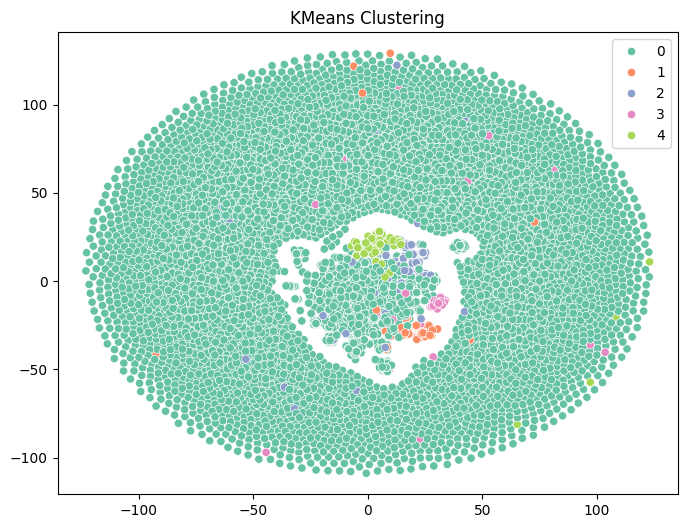

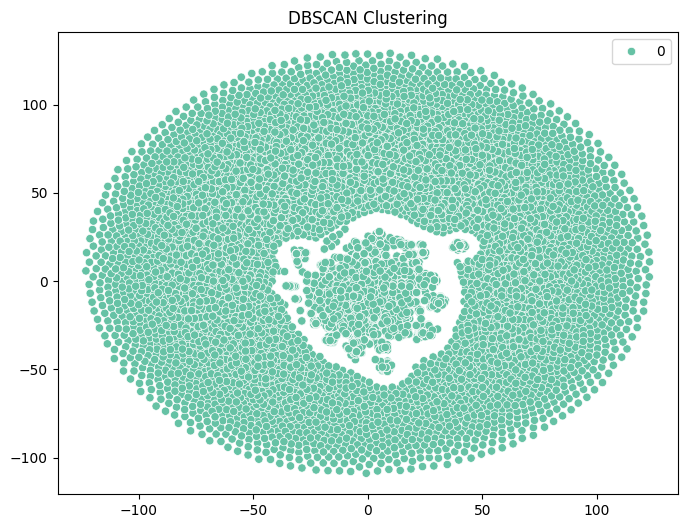

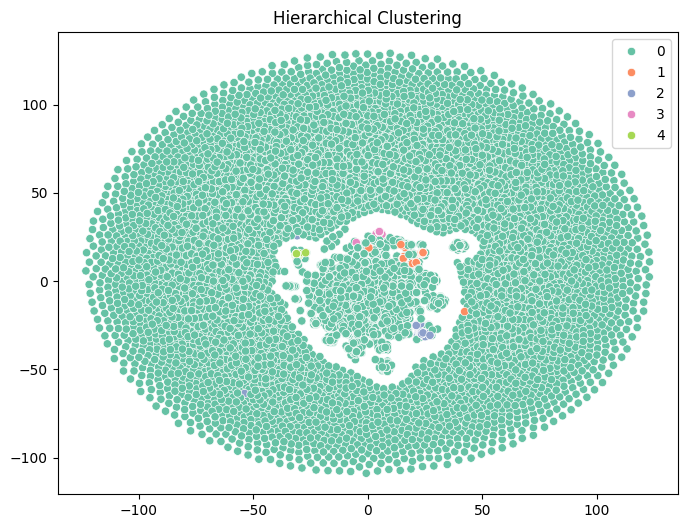

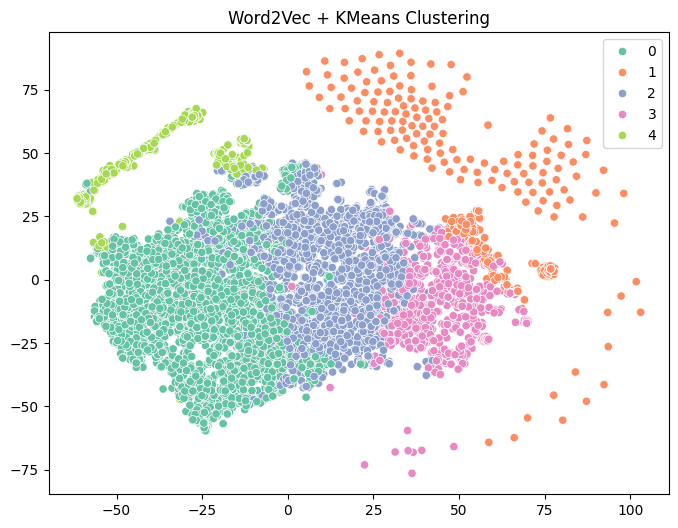

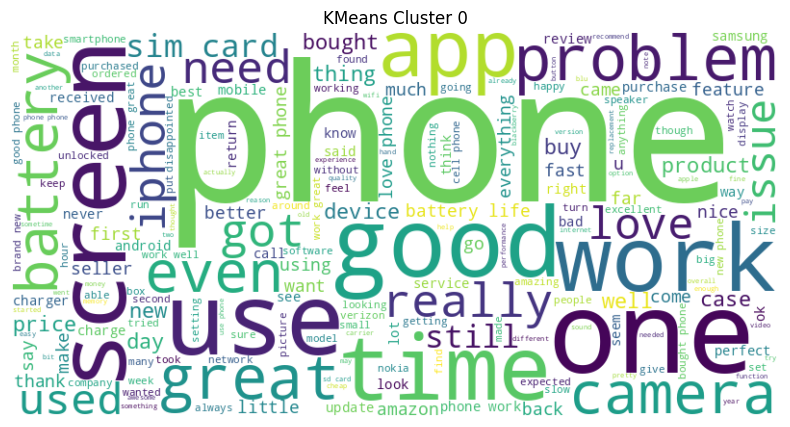

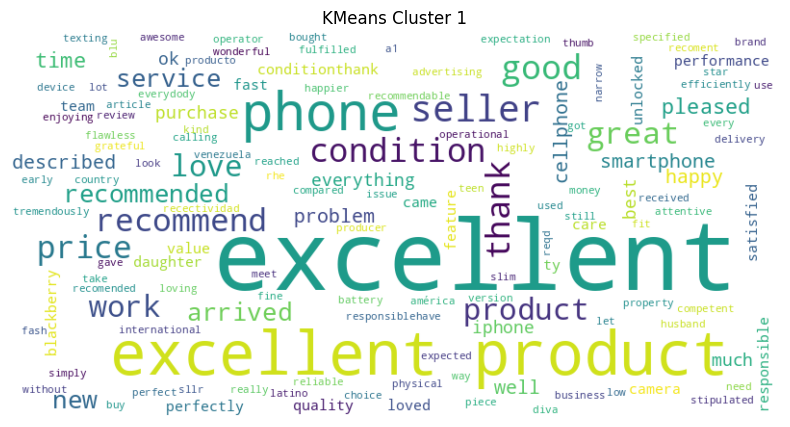

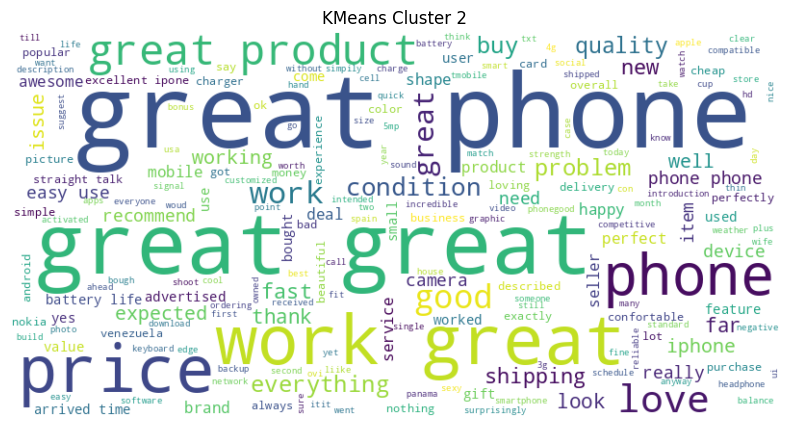

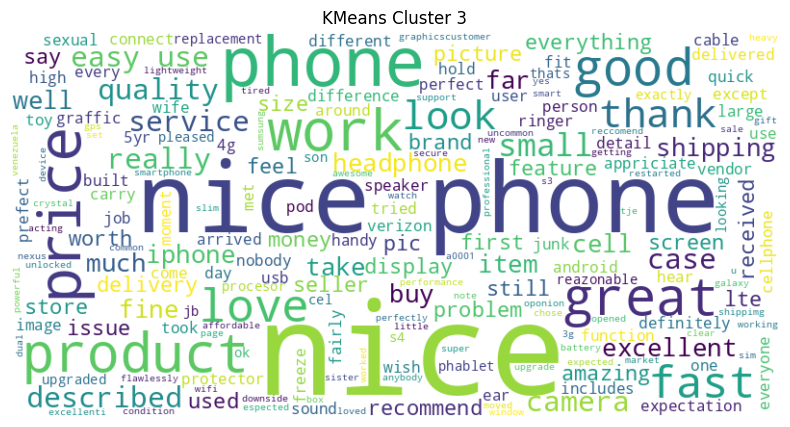

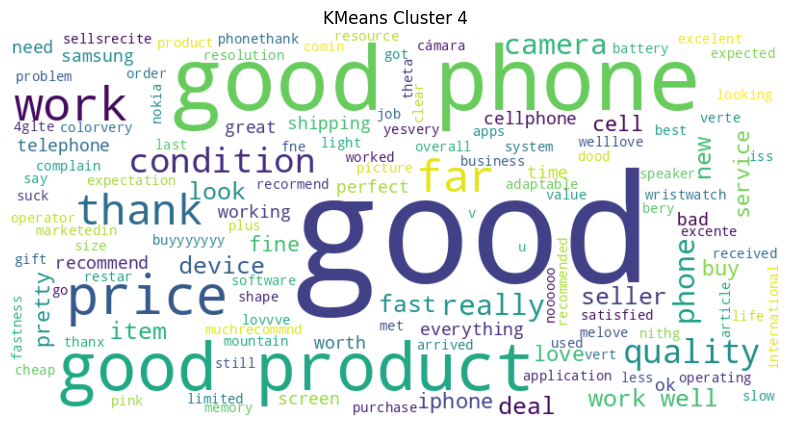

In [1]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from wordcloud import WordCloud
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# STEP 2: LOAD DATASET
df = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')
print(df.info())

# STEP 3: EDA
print("\nSample Reviews:\n", df['Reviews'].head())
df = df.dropna(subset=['Reviews'])

# STEP 4: PREPROCESSING
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

def preprocess_text(text):
    tokens = tokenizer.tokenize(str(text).lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_reviews'] = df['Reviews'].apply(preprocess_text)

# STEP 5: TF-IDF VECTORIZATION
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_reviews'])

# Reduce data for quick clustering
sample_size = 10000
df_sample = df.sample(n=sample_size, random_state=42)
X_sample = tfidf_vectorizer.transform(df_sample['cleaned_reviews'])

# STEP 6: KMEANS
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X_sample)
df_sample['kmeans_cluster'] = kmeans_labels

# STEP 7: DBSCAN
dbscan = DBSCAN(eps=1.2, min_samples=10, metric='cosine')
dbscan_labels = dbscan.fit_predict(X_sample)
df_sample['dbscan_cluster'] = dbscan_labels

# STEP 8: HIERARCHICAL
hierarchical = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_sample.toarray())
df_sample['hierarchical_cluster'] = hierarchical_labels

# STEP 9: WORD2VEC + KMEANS
tokenized_reviews = df_sample['cleaned_reviews'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

def document_vector(doc):
    vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.array([document_vector(doc) for doc in tokenized_reviews])
w2v_kmeans = KMeans(n_clusters=5, random_state=42)
w2v_labels = w2v_kmeans.fit_predict(X_w2v)
df_sample['w2v_kmeans_cluster'] = w2v_labels

# STEP 10: VISUALIZATION
def plot_clusters(data, labels, title):
    tsne = TSNE(n_components=2, perplexity=50, random_state=42)
    tsne_data = tsne.fit_transform(data.toarray() if hasattr(data, "toarray") else data)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=labels, palette='Set2', legend='full')
    plt.title(title)
    plt.show()

plot_clusters(X_sample, kmeans_labels, "KMeans Clustering")
plot_clusters(X_sample, dbscan_labels, "DBSCAN Clustering")
plot_clusters(X_sample, hierarchical_labels, "Hierarchical Clustering")
plot_clusters(X_w2v, w2v_labels, "Word2Vec + KMeans Clustering")

# STEP 11: WORDCLOUDS
for cluster_num in range(5):
    text = " ".join(df_sample[df_sample['kmeans_cluster'] == cluster_num]['cleaned_reviews'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"KMeans Cluster {cluster_num}")
    plt.show()


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

K-Means produced clear and well-separated clusters but relied on assumptions like spherical shapes and required the number of clusters to be predefined. DBSCAN effectively identified dense regions and handled noise, but it struggled with high-dimensional TF-IDF data, often labeling many reviews as outliers. Hierarchical clustering revealed relationships between reviews in a tree-like structure and was helpful for visual exploration, though it was computationally intensive and sensitive to the linkage method. Word2Vec combined with K-Means resulted in more meaningful and semantically grouped clusters by capturing word context, offering better topic similarity than TF-IDF-based methods. BERT-based clustering, if implemented, would likely deliver the most coherent and context-aware clusters by using deep contextual embeddings, making it superior in understanding the nuances of language compared to traditional approaches.

**Write your response here:**

.

.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises and on Teaching Assistant by filling this form:

https://docs.google.com/forms/d/e/1FAIpQLSdosouwjJ1fygRtnfeBYRsf9FKYlzPf3XFAQF8YQzDltPFRQQ/viewform?usp=dialog

**(Your submission will not be graded if this question is left unanswered)**

